# Convert Images to Clouds and viceversa

Here we will try to convert an image into a cloud distribution

In [70]:
import torch
import torch.nn as nn
from torch import optim

import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from random import random

import tifffile as tiff

In [161]:
def image2cloud(img, threshold=0.2, err=1.0):
    assert img.ndim == 2
    H,W = img.shape
    x,y=[],[]
    while img.sum() > 0.:
        indices = torch.where(img > 0)
        i,j = indices[0][0],indices[1][0]
        img[i,j] = torch.clip(img[i,j]-threshold,0,None)
        noise = random()*err
        x.append(j.item()+noise)
        y.append((H-1)-i.item()+noise)
    return (x,y)

def cloud2image(x,y, H=28, W=28):
    img = torch.zeros((H,W))
    
    for i in range(len(x)):
        img[(H-1)-int(y[i]), int(x[i])] += 1
        
    return img/img.max()

# MNIST Dataset

In [108]:
transform = transforms.Compose([
                transforms.PILToTensor(),
                transforms.ConvertImageDtype(torch.float),
                
            ])

trainset = torchvision.datasets.MNIST('./data', train= True, transform = transform, target_transform = None, download = True)
testset = torchvision.datasets.MNIST('./data', train= False, transform = transform, target_transform = None, download = True)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

Tot Pixels: 900
Tot Datapoints: 753


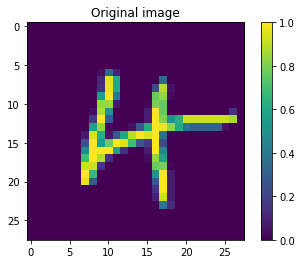

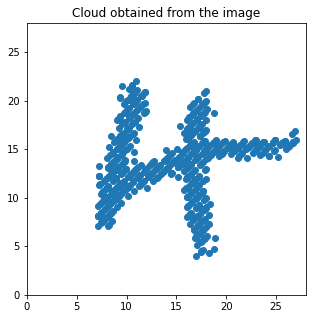

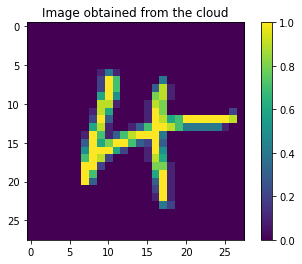

In [205]:
x,y = next(iter(train_loader))
# img = (x[0,0]*255).int()
img = x[0,0]

plt.figure()
plt.imshow(img)
plt.colorbar()
plt.title('Original image')

x,y = image2cloud(img,threshold=0.1)
    
plt.figure(figsize=[5,5])
plt.scatter(x,y)
plt.xlim([0,28])
plt.ylim([0,28])
plt.title('Cloud obtained from the image')

img = cloud2image(x,y)

plt.figure()
plt.imshow(img)
plt.colorbar()
plt.title('Image obtained from the cloud')

print('Tot Pixels:', H*W)
print('Tot Datapoints:', len(x))

plt.show()

# Drone Image

In [185]:
from torch import Tensor

def image_info(image):
    shape = image.shape
    if len(shape) == 3:
        if isinstance(image, Tensor):
            C, H, W = shape
        elif isinstance(image, np.ndarray):
            H, W, C = shape
        else:
            raise NotImplementedError("Expected torch.Tensor or np.ndarray")
    elif len(shape) == 2:
        H, W = shape
        C = 1
    else:
        raise NotImplementedError("Image shape is {shape}. It expected image with shape (H,W), (C,H,W) or (H,W,C)")

    return C, H, W

def split_mosaic(mosaic, k: list = (2,2)):
    """
        Split a spectral camera mosaic into a multi-channel image
    
        Args:
            mosaic: 
                spectral mosaic, shape: (H,W)
            k: 
                spectral mosaic's kernel sizes, shape: (kx,ky). Default Bayer kernels k=(2,2)
        Return:
            imgs (np.ndarray or torch.Tensor): 
                Images with different wavelengths splitted in channels.
                Shape: (C, H//kx, W//ky) if type == Tensor
                Shape: (H//kx, W//ky, C) if type == np.ndarray

    """

    _, H, W = image_info(mosaic)
    k_row,k_column = k

    x_max = k_row*(H//k_row) # integer number of patterns
    y_max = k_column*(W//k_column)
    
    mosaic = mosaic[0:x_max, 0:y_max]
    all_images = [mosaic[i::k_row, j::k_column] for i in range(k_row) for j in range(k_column)] # some list comprehension will save us here ...

    images = stack_dtype(all_images)

    return images


def stack_dtype(var):
    if isinstance(var[0], Tensor):
        return torch.stack(var)
    elif isinstance(var[0], np.ndarray):
        return np.stack(var, axis=2)
    else:
        raise NotImplementedError("Expected torch.Tensor or np.ndarray")

Tot Pixels: 900
Tot Datapoints: 2059


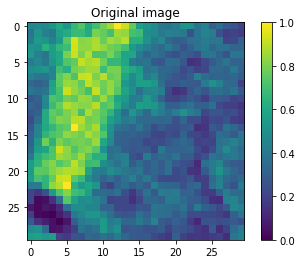

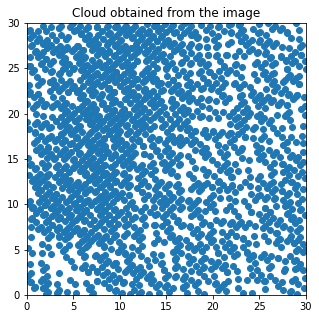

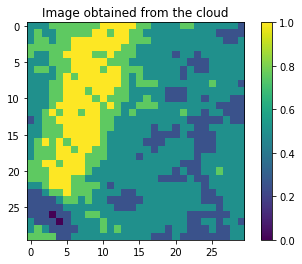

In [208]:
img_name = './data/drone/original/images_tiles_256/tile0000_00000.tiff'

img_size=30

img = torch.tensor(tiff.imread(img_name))
img = split_mosaic(img)[0,:img_size,:img_size]

norm = lambda x: (x-x.min())/(x.max()-x.min())
img = norm(img)

H,W = img.shape

plt.figure()
plt.imshow(img)
plt.colorbar()
plt.title('Original image')

x,y = image2cloud(img,threshold=0.25)
    
plt.figure(figsize=[5,5])
plt.scatter(x,y)
plt.xlim([0,H])
plt.ylim([0,W])
plt.title('Cloud obtained from the image')

img = cloud2image(x,y, H=H, W=W)

plt.figure()
plt.imshow(img)
plt.colorbar()
plt.title('Image obtained from the cloud')

print('Tot Pixels:', H*W)
print('Tot Datapoints:', len(x))

plt.show()

### Diffusion + Noise

In [11]:
blur = transforms.GaussianBlur((5,5), sigma=(1.0, 1.0))

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
add_noise = AddGaussianNoise(0.,0.2)

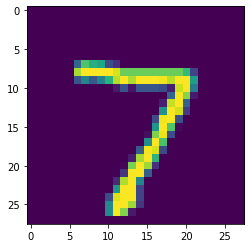

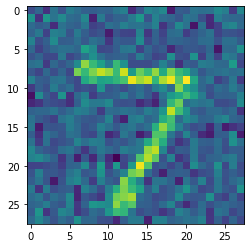

In [28]:
x,y = next(iter(test_loader))

diffused = add_noise(blur(x))
diffused = add_noise(x)
# diffused = blur(x)

plt.figure()
plt.imshow(x[0,0])
plt.figure()
plt.imshow(diffused[0,0])
plt.show()

### FFT Noisy image

Digit number 7


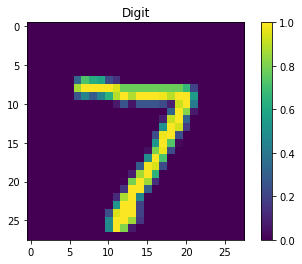

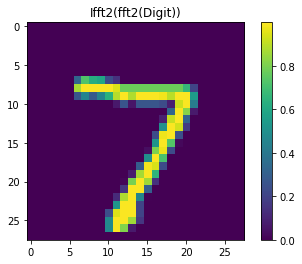

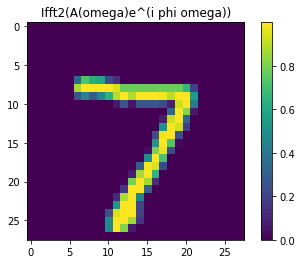

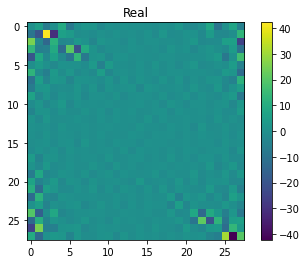

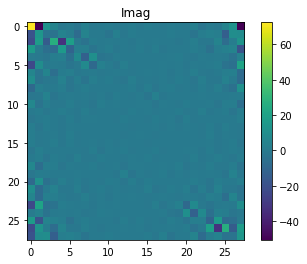

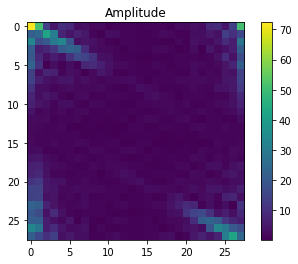

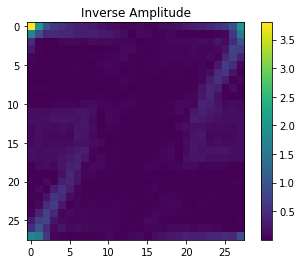

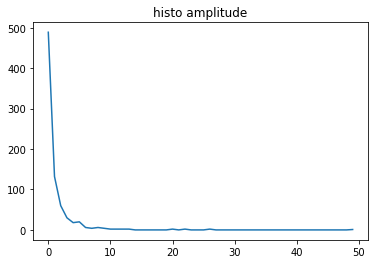

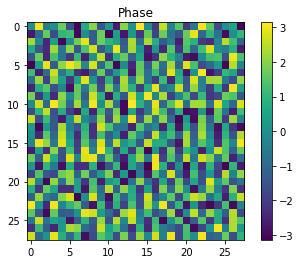

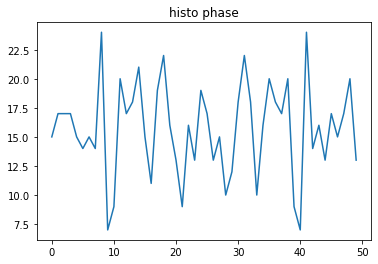

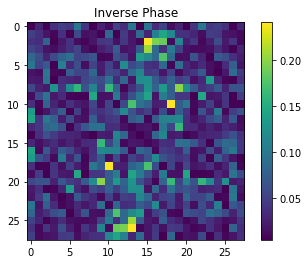

Digit number 7


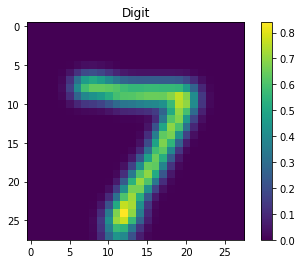

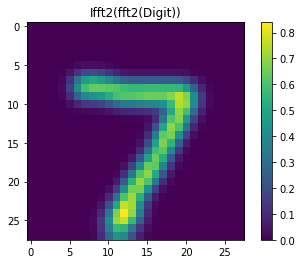

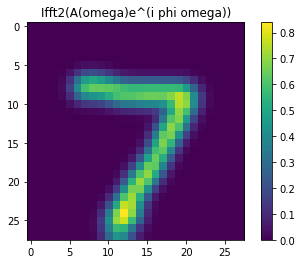

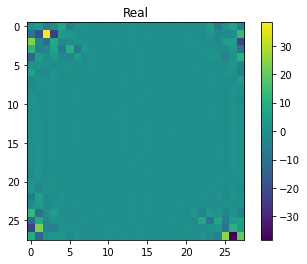

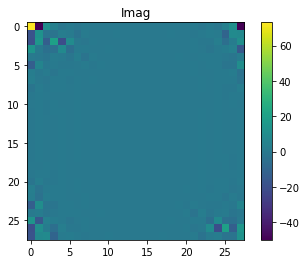

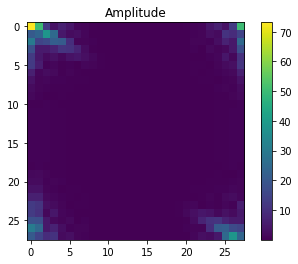

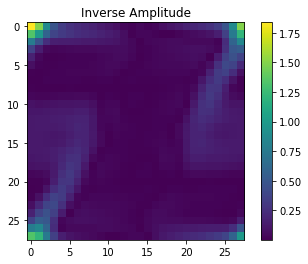

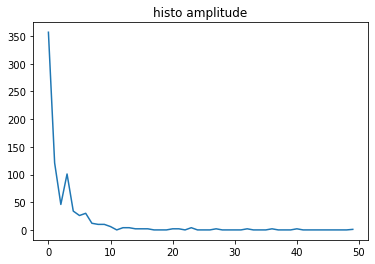

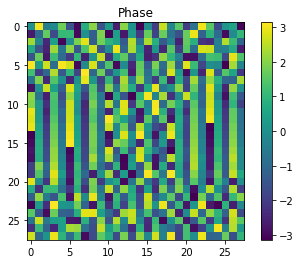

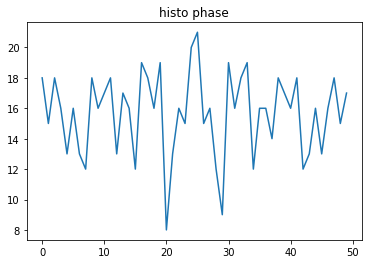

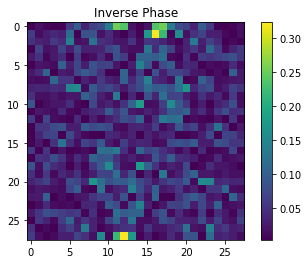

Digit number 7


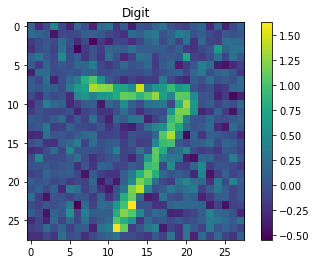

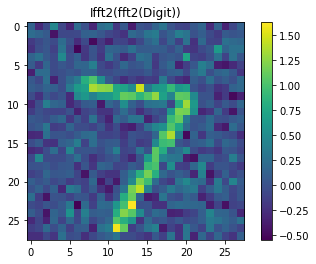

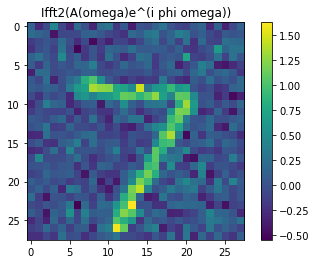

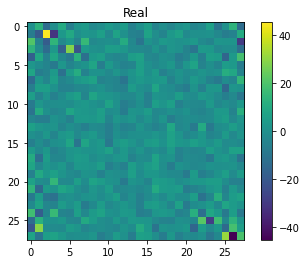

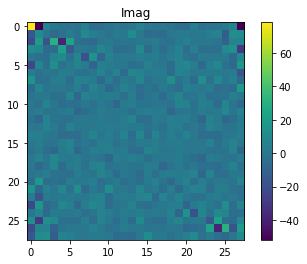

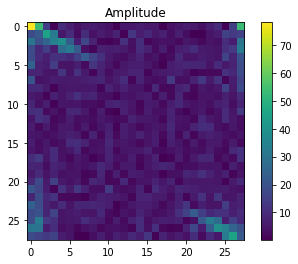

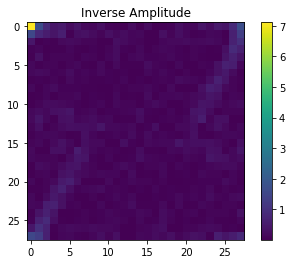

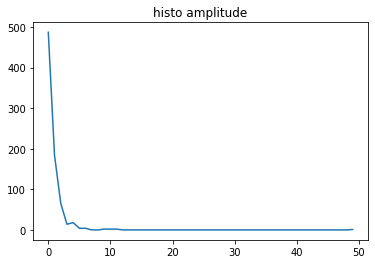

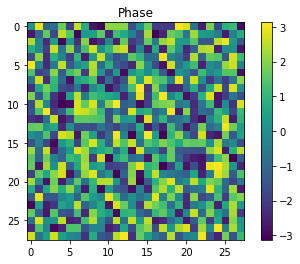

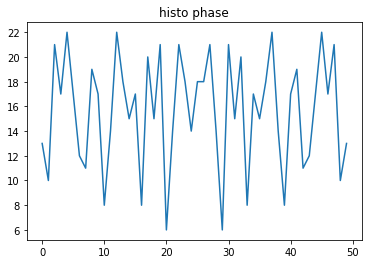

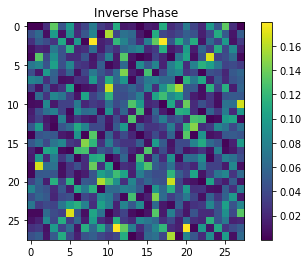

Digit number 7


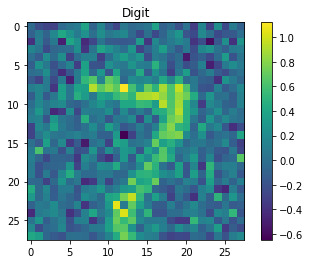

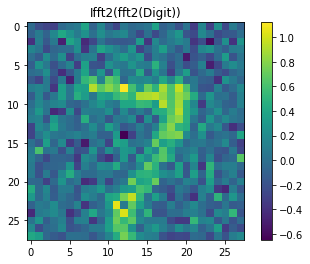

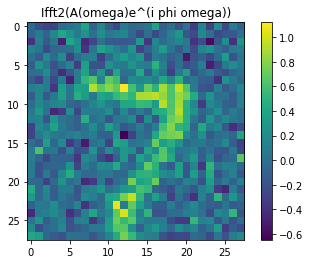

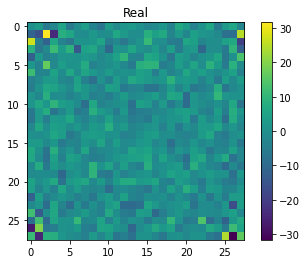

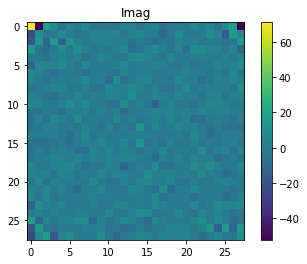

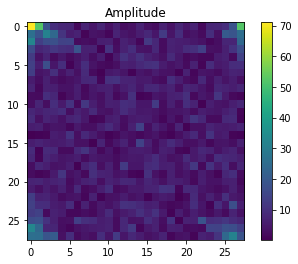

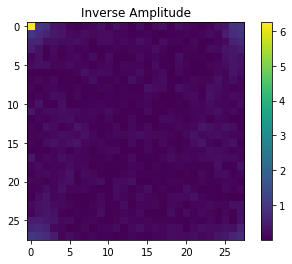

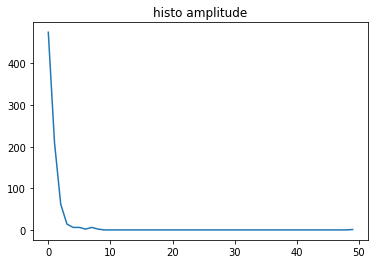

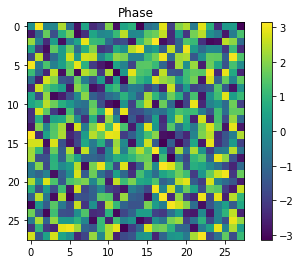

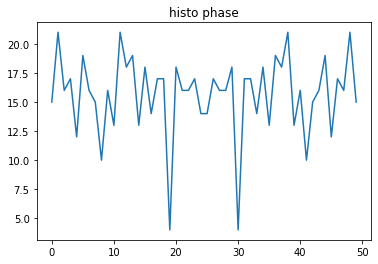

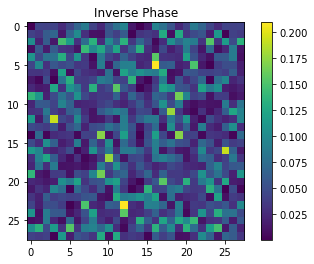

In [73]:
x,y = next(iter(test_loader))

for x in [x,blur(x),add_noise(x), add_noise(blur(x))]:
    n=0
    print(f'Digit number {y[n].item()}')

    fft_noise = torch.fft.fft2(x)

    ifft_noise = torch.real(torch.fft.ifft2(fft_noise))

    re_fft = torch.imag(fft_noise)
    im_fft = torch.real(fft_noise)

    abs_fft = torch.abs(fft_noise)
    abs_ifft = torch.fft.ifft2(abs_fft)
    abs_ifft = torch.abs(abs_ifft)

    phase_fft = torch.angle(fft_noise)
    phase_ifft = torch.fft.ifft2(phase_fft)
    phase_ifft = torch.abs(phase_ifft)

    z = torch.complex(abs_fft*torch.cos(phase_fft),abs_fft*torch.sin(phase_fft))
    z_ifft = torch.real(torch.fft.ifft2(z))

    plt.figure()
    plt.imshow(x[n,0])
    plt.colorbar()
    plt.title('Digit')

    plt.figure()
    plt.imshow(ifft_noise[n,0])
    plt.colorbar()
    plt.title('Ifft2(fft2(Digit))')

    plt.figure()
    plt.imshow(z_ifft[n,0])
    plt.colorbar()
    plt.title('Ifft2(A(omega)e^(i phi omega))')

    plt.figure()
    plt.imshow(re_fft[n,0])
    plt.colorbar()
    plt.title('Real')

    plt.figure()
    plt.imshow(im_fft[n,0])
    plt.colorbar()
    plt.title('Imag')

    plt.figure()
    plt.imshow(abs_fft[n,0])
    plt.colorbar()
    plt.title('Amplitude')

    plt.figure()
    plt.imshow(abs_ifft[n,0])
    plt.colorbar()
    plt.title('Inverse Amplitude')

    histo = torch.histc(abs_ifft[n,0].reshape(-1), 50)

    plt.figure()
    plt.plot(histo)
    plt.title('histo amplitude')

    plt.figure()
    plt.imshow(phase_fft[n,0])
    plt.colorbar()
    plt.title('Phase')

    histo = torch.histc(phase_fft[n,0].reshape(-1), 50)

    plt.figure()
    plt.plot(histo)
    plt.title('histo phase')

    plt.figure()
    plt.imshow(phase_ifft[n,0])
    plt.colorbar()
    plt.title('Inverse Phase')


    plt.show()

We applied the fft to a signal A(x). 

The signal can be reconstructed from ifft(|A(w)|e^(-iwt)). 

Here we reconstruct the A(x) by mixing the phase and the amplitude of different perturbed signals

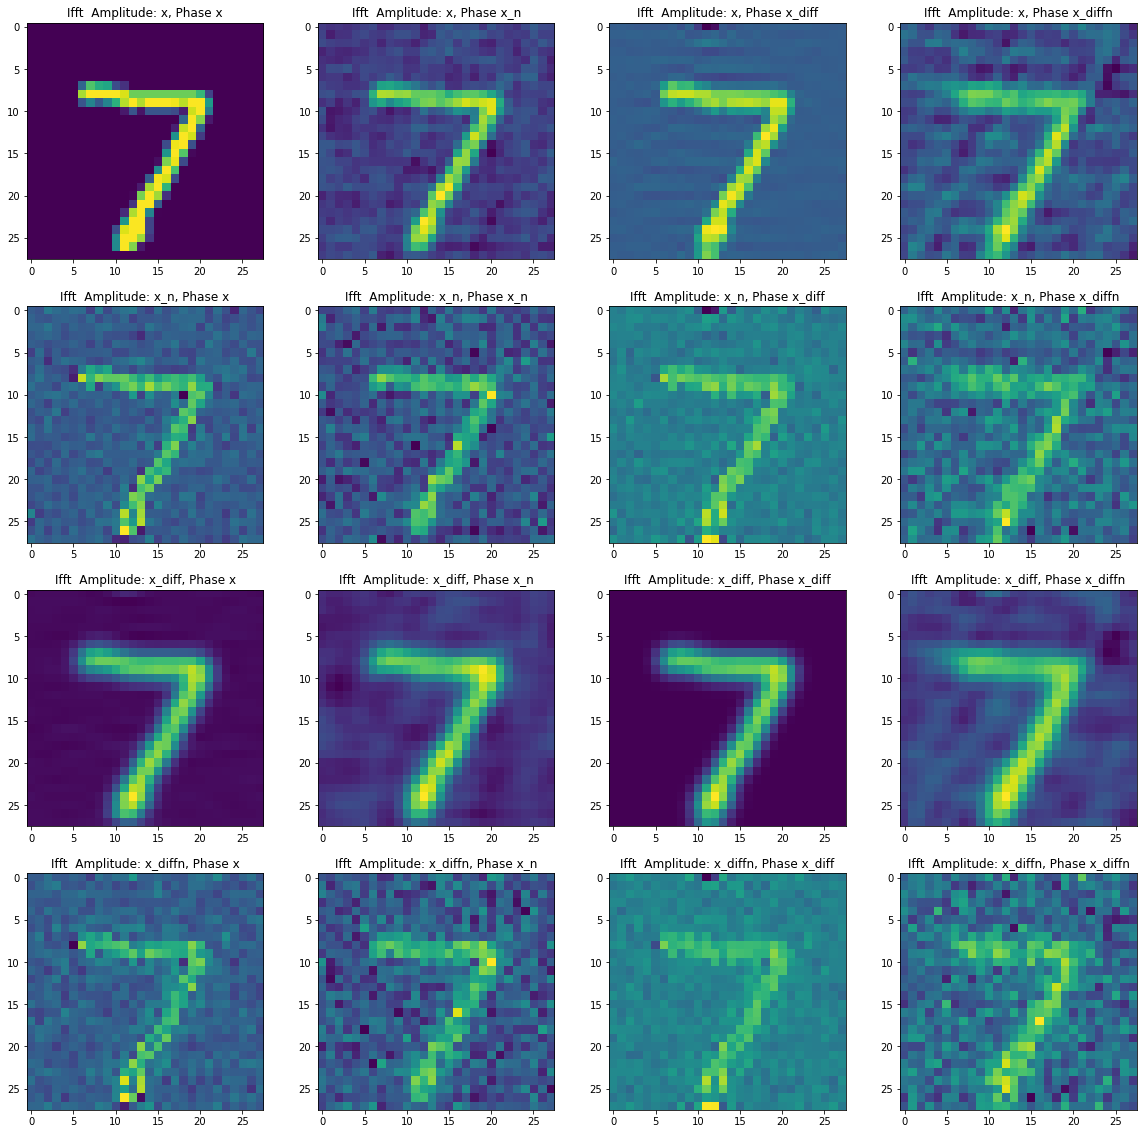

In [88]:


x,y = next(iter(test_loader))

x_n = add_noise(x)
x_diff = blur(x)
x_diffn = add_noise(blur(x))

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

fig,ax = plt.subplots(nrows=4,ncols=4, figsize=(20,20))
for i,x1 in enumerate([x,x_n,x_diff,x_diffn]):
    for j,x2 in enumerate([x,x_n,x_diff,x_diffn]):
        fft_1 = torch.fft.fft2(x1)
        fft_2 = torch.fft.fft2(x2)
        
        abs_fft_1 = torch.abs(fft_1)
        phase_fft_2 = torch.angle(fft_2)
        
        z = torch.complex(abs_fft_1*torch.cos(phase_fft_2),abs_fft_1*torch.sin(phase_fft_2))
        z_ifft = torch.real(torch.fft.ifft2(z))

        ax[i,j].imshow(z_ifft[0,0])
        ax[i,j].set_title(f'Ifft  Amplitude: {namestr(x1, globals())[0]}, Phase {namestr(x2, globals())[0]}' )
       
plt.show()

### Estimate Phase from Intensity

In [68]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784*3))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var
    
# build model
vae = VAE(x_dim=784*3, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

vae

VAE(
  (fc1): Linear(in_features=2352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=2352, bias=True)
)

In [71]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in valid_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(valid_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))